In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
import mnist_reader
from sklearn.decomposition import PCA
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis


x_train, y_train = mnist_reader.load_data('../../data/oracle', kind='train')
x_test, y_test = mnist_reader.load_data('../../data/oracle', kind='t10k')

x_train = x_train.reshape(-1, 1, 28, 28).astype(np.float32) / 255.0
x_test = x_test.reshape(-1, 1, 28, 28).astype(np.float32) / 255.0

y_train = y_train.astype(np.int64)
y_test = y_test.astype(np.int64)

train_dataset = TensorDataset(torch.tensor(x_train), torch.tensor(y_train))
test_dataset = TensorDataset(torch.tensor(x_test), torch.tensor(y_test))

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64)

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3)
        self.pool1 = nn.MaxPool2d(2)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3)
        self.pool2 = nn.MaxPool2d(2)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 5 * 5, 128)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x, return_features=False):
        x = self.pool1(F.relu(self.conv1(x)))
        x = self.pool2(F.relu(self.conv2(x)))
        x = self.flatten(x)
        features = F.relu(self.fc1(x))
        if return_features:
            return features
        return self.fc2(features)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SimpleCNN(num_classes=10).to(device)
model.load_state_dict(torch.load("best_cnn_model.pt", map_location=torch.device("cpu")))
model.eval()

def extract_features(model, dataloader):
    model.eval()
    features = []
    labels = []
    with torch.no_grad():
        for images, targets in dataloader:
            images = images.to(device)
            feats = model(images, return_features=True)
            features.append(feats.cpu().numpy())
            labels.append(targets.numpy())
    return np.vstack(features), np.hstack(labels)

X_train_feats, y_train = extract_features(model, train_loader)
X_test_feats, y_test = extract_features(model, test_loader)

lda_components = 9

lda = LinearDiscriminantAnalysis(n_components=lda_components)
x_train_lda = lda.fit_transform(X_train_feats, y_train)
x_test_lda = lda.transform(X_test_feats)

The size of train set: 27222
The size of t10k set: 3000


C:\Users\ted12\AppData\Local\Temp\ipykernel_79340\913432386.py:53: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("best_cnn_model.pt", map_lo

In [2]:
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score

# LDA + K-means clustering

n_clusters = 10

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(x_test_lda)

ari = adjusted_rand_score(y_test, cluster_labels)
print(f"Adjusted Rand Index (ARI): {ari:.4f}")

Adjusted Rand Index (ARI): 0.7246


c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


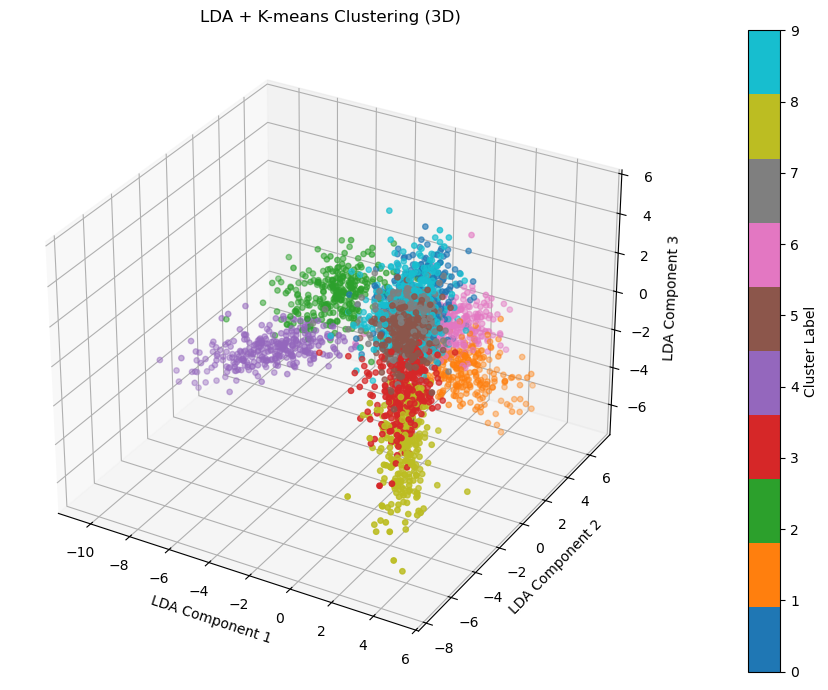

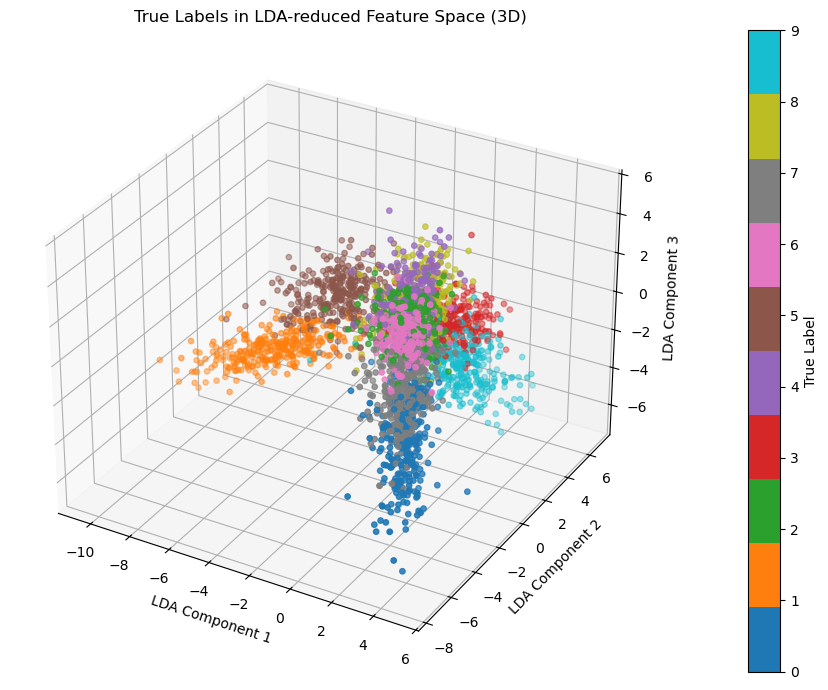

In [4]:
from mpl_toolkits.mplot3d import Axes3D  # 3D 畫圖工具

# LDA 可降到最多 9 維（classes - 1），這裡我們改成 3 維
lda_components = 3
lda = LinearDiscriminantAnalysis(n_components=lda_components)
x_train_lda = lda.fit_transform(X_train_feats, y_train)
x_test_lda = lda.transform(X_test_feats)
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter = ax.scatter(x_test_lda[:, 0], x_test_lda[:, 1], x_test_lda[:, 2],
                     c=cluster_labels, cmap='tab10', s=15)
ax.set_title("LDA + K-means Clustering (3D)")
ax.set_xlabel("LDA Component 1")
ax.set_ylabel("LDA Component 2")
ax.set_zlabel("LDA Component 3")
fig.colorbar(scatter, ax=ax, pad=0.1, ticks=range(n_clusters), label="Cluster Label")
plt.tight_layout()
plt.savefig("lda_kmeans_clusters_3d.png")
plt.show()
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')
scatter_gt = ax.scatter(x_test_lda[:, 0], x_test_lda[:, 1], x_test_lda[:, 2],
                        c=y_test, cmap='tab10', s=15)
ax.set_title("True Labels in LDA-reduced Feature Space (3D)")
ax.set_xlabel("LDA Component 1")
ax.set_ylabel("LDA Component 2")
ax.set_zlabel("LDA Component 3")
fig.colorbar(scatter_gt, ax=ax, pad=0.1, ticks=range(10), label="True Label")
plt.tight_layout()
plt.savefig("lda_true_labels_3d.png")
plt.show()


In [ ]:
from sklearn.mixture import GaussianMixture
from sklearn.metrics import adjusted_rand_score

# LDA + EM algorithm

n_components = 10


gmm = GaussianMixture(n_components=n_components, covariance_type='full', random_state=42)
gmm.fit(x_test_lda)


cluster_labels = gmm.predict(x_test_lda)


ari = adjusted_rand_score(y_test, cluster_labels)
print(f"EM Clustering ARI: {ari:.4f}")

c:\Users\ted12\anaconda3\envs\NLP\Lib\site-packages\sklearn\cluster\_kmeans.py:1334: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=12.
  warnings.warn(


EM Clustering ARI: 0.7612


In [ ]:
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

gnb = GaussianNB()
gnb.fit(x_train_lda, y_train)

y_pred = gnb.predict(x_test_lda)
accuracy = accuracy_score(y_test, y_pred)
print(f"✅ Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=np.unique(y_test), yticklabels=np.unique(y_test))
plt.title("Confusion Matrix: CNN Feature + LDA + GNB")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join("../results/CNN/LDA_GNB", "confusion_matrix_cnn_lda_gnb.png"))
plt.close()

report = classification_report(y_test, y_pred, output_dict=True)
flat_report = {
    f"{label}_{metric}": score
    for label, scores in report.items() if isinstance(scores, dict)
    for metric, score in scores.items()
}
flat_report["accuracy"] = accuracy
flat_report["lda_components"] = lda_components

df = pd.DataFrame([flat_report])
df.to_csv(os.path.join("../results/CNN/LDA_GNB", "classification_report_cnn_lda_gnb.csv"), index=False)


✅ Accuracy: 0.9010
              precision    recall  f1-score   support

           0       0.94      0.87      0.90       300
           1       0.95      0.96      0.96       300
           2       0.93      0.92      0.92       300
           3       0.85      0.86      0.85       300
           4       0.83      0.91      0.86       300
           5       0.92      0.93      0.92       300
           6       0.91      0.92      0.91       300
           7       0.89      0.88      0.88       300
           8       0.88      0.91      0.89       300
           9       0.94      0.85      0.90       300

    accuracy                           0.90      3000
   macro avg       0.90      0.90      0.90      3000
weighted avg       0.90      0.90      0.90      3000



In [ ]:
from sklearn.svm import SVC
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix

clf = SVC(kernel='rbf', gamma='scale', probability=True)
clf.fit(x_train_lda, y_train)

y_pred = clf.predict(x_test_lda)

accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred, output_dict=True)
print(f"✅ Accuracy: {accuracy:.4f}")
print(classification_report(y_test, y_pred))

cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=np.unique(y_test),
            yticklabels=np.unique(y_test))
plt.title("Confusion Matrix: CNN Feature + LDA + SVM")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.tight_layout()
plt.savefig(os.path.join("../results/CNN/LDA_SVM", "confusion_matrix_cnn_lda_svm.png"))
plt.close()

flat_report = {
    f"{label}_{metric}": value
    for label, scores in report.items() if isinstance(scores, dict)
    for metric, value in scores.items()
}
flat_report["lda_components"] = lda_components
flat_report["accuracy"] = accuracy

df = pd.DataFrame([flat_report])
df.to_csv(os.path.join("../results/CNN/LDA_SVM", "classification_report_cnn_lda_svm.csv"), index=False)


✅ Accuracy: 0.9127
              precision    recall  f1-score   support

           0       0.92      0.92      0.92       300
           1       0.95      0.98      0.96       300
           2       0.93      0.94      0.93       300
           3       0.88      0.88      0.88       300
           4       0.87      0.89      0.88       300
           5       0.94      0.92      0.93       300
           6       0.93      0.90      0.92       300
           7       0.91      0.88      0.89       300
           8       0.87      0.92      0.89       300
           9       0.93      0.89      0.91       300

    accuracy                           0.91      3000
   macro avg       0.91      0.91      0.91      3000
weighted avg       0.91      0.91      0.91      3000

